In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
# from IPython.display import display, HTML
# import bbknn
import time

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

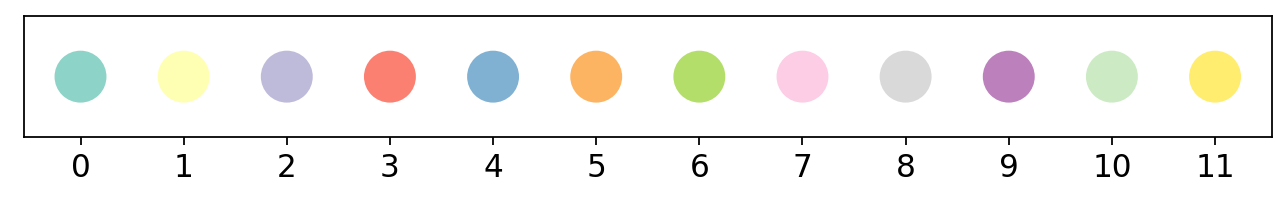

In [4]:
def get_colors(factor=0, lighter=True):
    plt.figure(figsize=(10,1))
    colors = np.array(plt.get_cmap('Set3').colors)
    if lighter:
        colors = colors + (1 - colors)*factor
    else:
        colors = c=colors*(1 - factor)
    colors = [mpl.colors.to_hex(i) for i in colors]
    plt.scatter(np.arange(12), [0]*12, c=colors, s=500)
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    ax.set_xticks(np.arange(12))
    plt.grid(False)
    return dict(zip(np.arange(12), colors))
colors = get_colors()

### Load in the data

In [5]:
with open('/data/xyzeq/10x/5prime_liver/downsample/10x.down.pkl','rb') as file:
    adata_10x = pkl.load(file)['mouse_down']

In [6]:
adata_xyz = sc.read_h5ad(prefix + 'box.data4/all_batches_mouse_only_processed.h5ad')

In [7]:
np.where(adata_xyz.raw.X > 0)

(array([   0,    0,    0, ..., 6622, 6622, 6622]),
 array([ 3347,  4385,  4924, ..., 55130, 55197, 55257]))

In [8]:
adata_xyz.raw.X[0, 3347]

0.6929356

Raw values have been transformed. Checking `spatial/notebooks/figures/XYZeq_fig3_decontaminated_clustering.ipynb`, it looks like they've only been log transformed.

In [9]:
adata_xyz.raw.X.sum(axis=1)

array([430.50928, 524.22565, 374.18756, ..., 956.88336, 259.64786,
       622.6367 ], dtype=float32)

Doesn't looks like they've been normalized per cell. This is good!

Adjust `var` names:

In [10]:
adata_xyz.var_names = [i[5:] for i in adata_xyz.var_names]
adata_xyz.var_names_make_unique()

In [11]:
new_raw = adata_xyz.raw.to_adata()
new_raw.var_names = [i[5:] for i in new_raw.var_names]
new_raw.var_names_make_unique()
adata_xyz.raw = new_raw

In [12]:
print(adata_10x.obs.columns)
print(adata_xyz.obs.columns)

Index(['mouse_counts', 'human_counts', 'percent_mito', 'n_counts', 'leiden',
       'celltype'],
      dtype='object')
Index(['batch', 'n_counts', 'log_counts', 'n_genes', 'barcode',
       'percent_mito_mouse', 'percent_mito_human', 'mouse_counts',
       'human_counts', 'ratio', 'cell_call', 'contam_init', 'tsne_density',
       'leiden', 'CellType', '__is_in_cluster__'],
      dtype='object')


In [13]:
adata_xyz.obs = adata_xyz.obs.rename(columns={'CellType': 'celltype'})

### Visualize

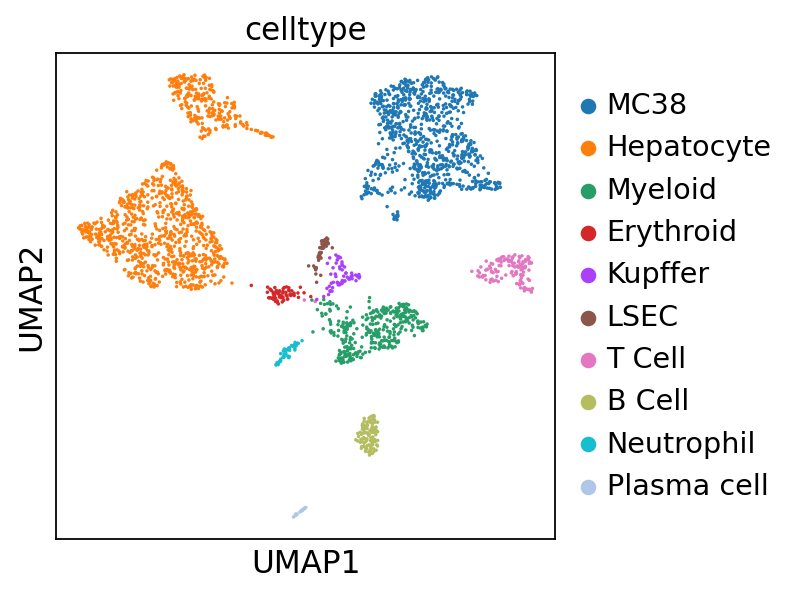

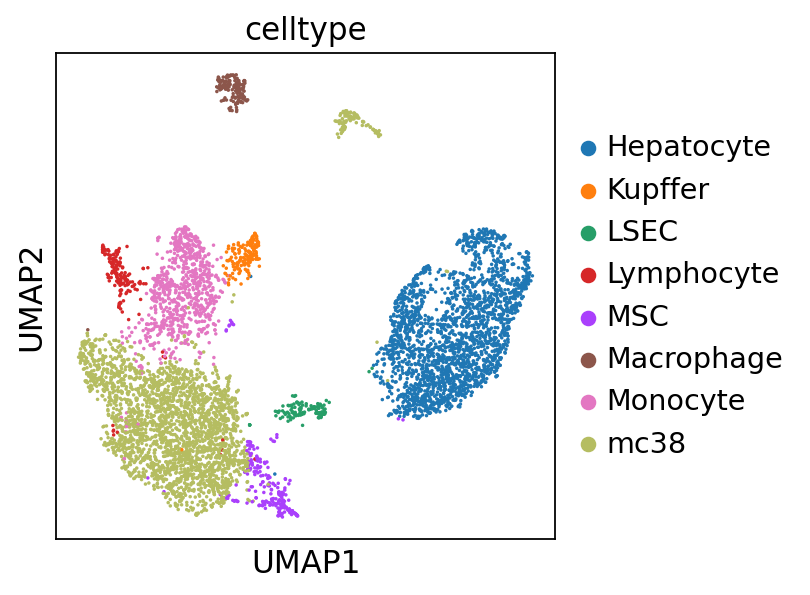

In [15]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['celltype',], size=10)

In [16]:
ctdict = dict()
ctdict['Myeloid'] = ['Macrophage', 'Monocyte']
# ctdict['XYZ_Monocyte'] = ['Monocyte']
ctdict['MC38'] = ['mc38']
ctdict['Kupffer'] = ['Kupffer']
ctdict['LSEC'] = ['LSEC']
ctdict['Lymphocyte'] = ['Lymphocyte']
ctdict['Hepatocyte'] = ['Hepatocyte']
ctdict['MSC'] = ['MSC']

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_xyz.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_xyz.obs['celltype'] = adata_xyz.obs['celltype'].astype('category')

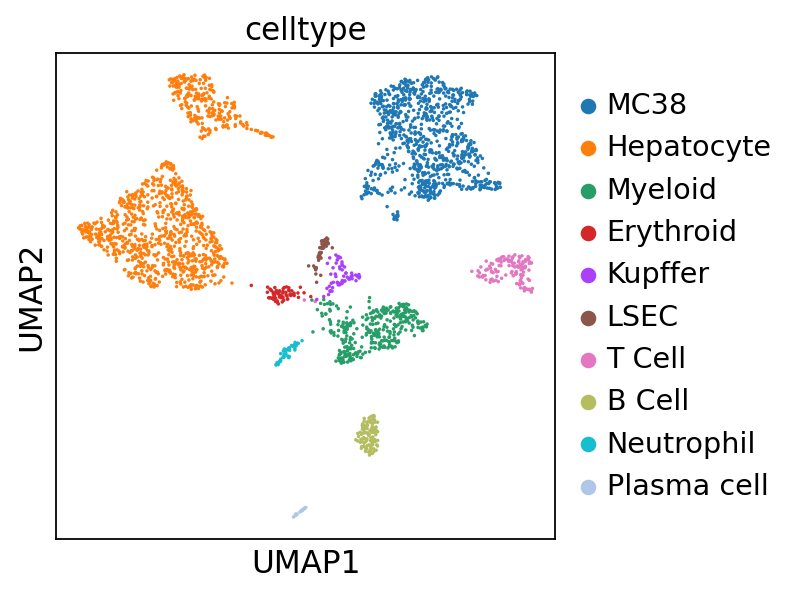

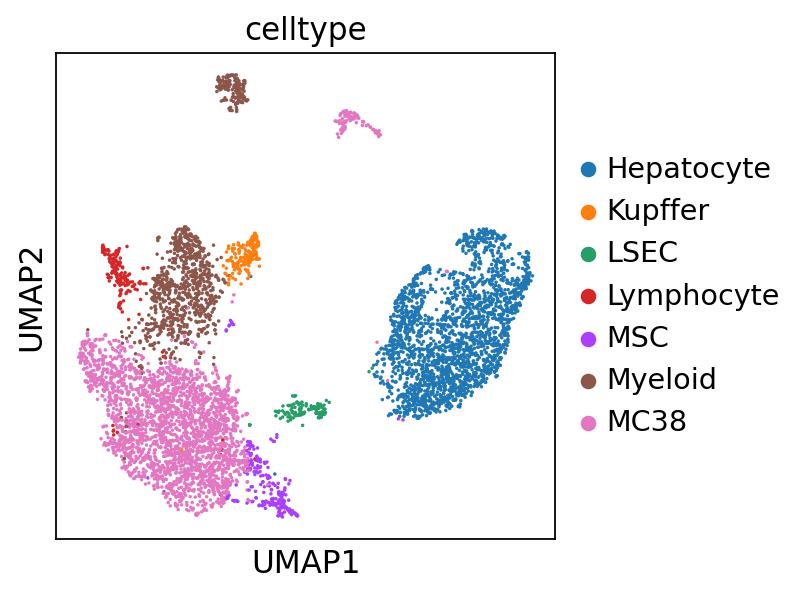

In [17]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['celltype'], size=10)

Make the colors match:

In [19]:
adata_10x.obs['celltype'].dtype.categories

Index(['MC38', 'Hepatocyte', 'Myeloid', 'Erythroid', 'Kupffer', 'LSEC',
       'T Cell', 'B Cell', 'Neutrophil', 'Plasma cell'],
      dtype='object')

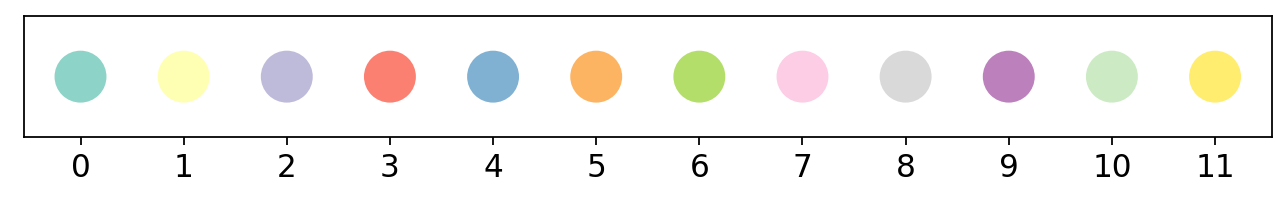

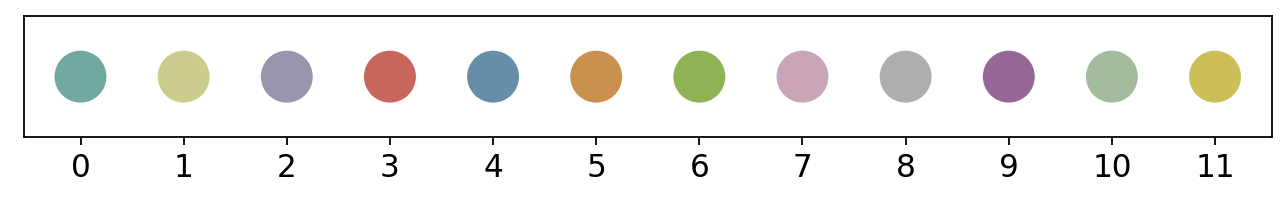

In [20]:
colors = get_colors()
dark_colors = get_colors(factor=0.2, lighter=False)

In [21]:
paper_colormap = {
    'Hepatocyte': colors[3],
    'Kupffer': colors[5],
    'LSEC': colors[4],
    'Lymphocyte': colors[2],
    'MSC': colors[0],
    'Macrophage': colors[10],
    'MC38': colors[11],
}

In [23]:
color_10x_mapper = {
    'MC38': paper_colormap['MC38'],
    'Myeloid': paper_colormap['Macrophage'],
    'Hepatocyte': paper_colormap['Hepatocyte'],
    'T Cell': paper_colormap['Lymphocyte'],
    'B Cell': colors[8],
    'Neutrophil': colors[6],
    'Plasma cell': dark_colors[8],
    'Erythroid': colors[7],
    'LSEC': paper_colormap['LSEC'],
    'Kupffer': paper_colormap['Kupffer']
}

In [25]:
color_xyz_mapper = {
    'MC38': paper_colormap['MC38'],
    'Myeloid': paper_colormap['Macrophage'],
    'Hepatocyte': paper_colormap['Hepatocyte'],
    'Lymphocyte': paper_colormap['Lymphocyte'],
    'LSEC': paper_colormap['LSEC'],
    'Kupffer': paper_colormap['Kupffer'],
    'MSC': paper_colormap['MSC']
}

In [26]:
for adata, mapper in zip([adata_xyz, adata_10x], 
                         [color_xyz_mapper, color_10x_mapper]
                        ):
    adata.uns['celltype_colors'] = adata.obs['celltype'].dtype.categories.map(mapper).tolist()

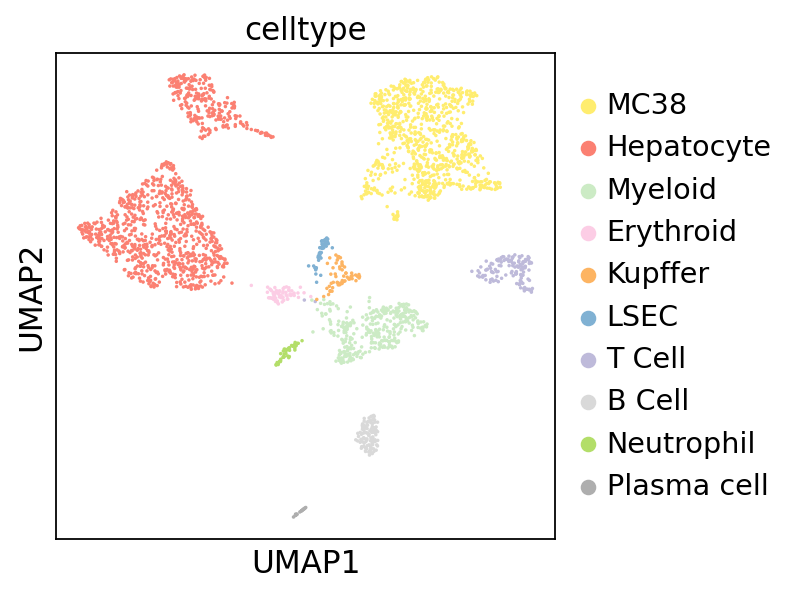

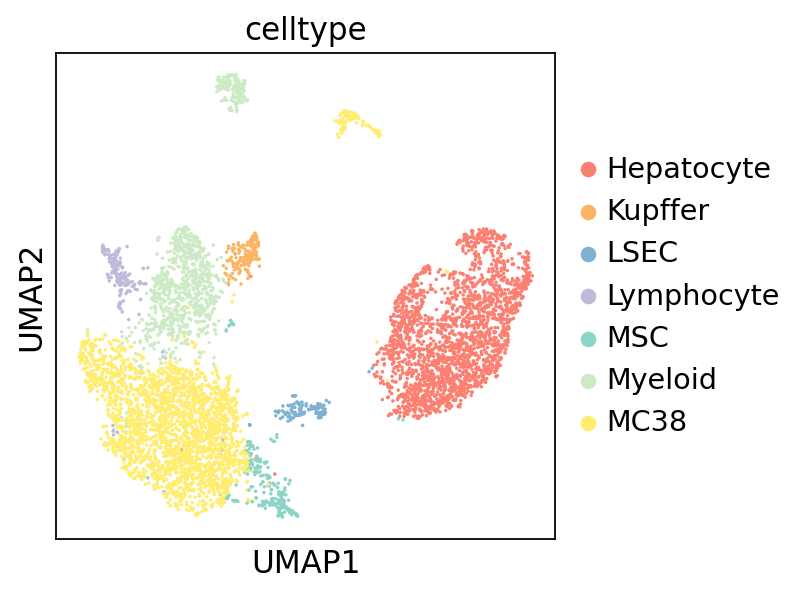

In [27]:
sc.pl.umap(adata_10x,color=['celltype'], size=10)
sc.pl.umap(adata_xyz,color=['celltype'], size=10)

### Ranking Genes

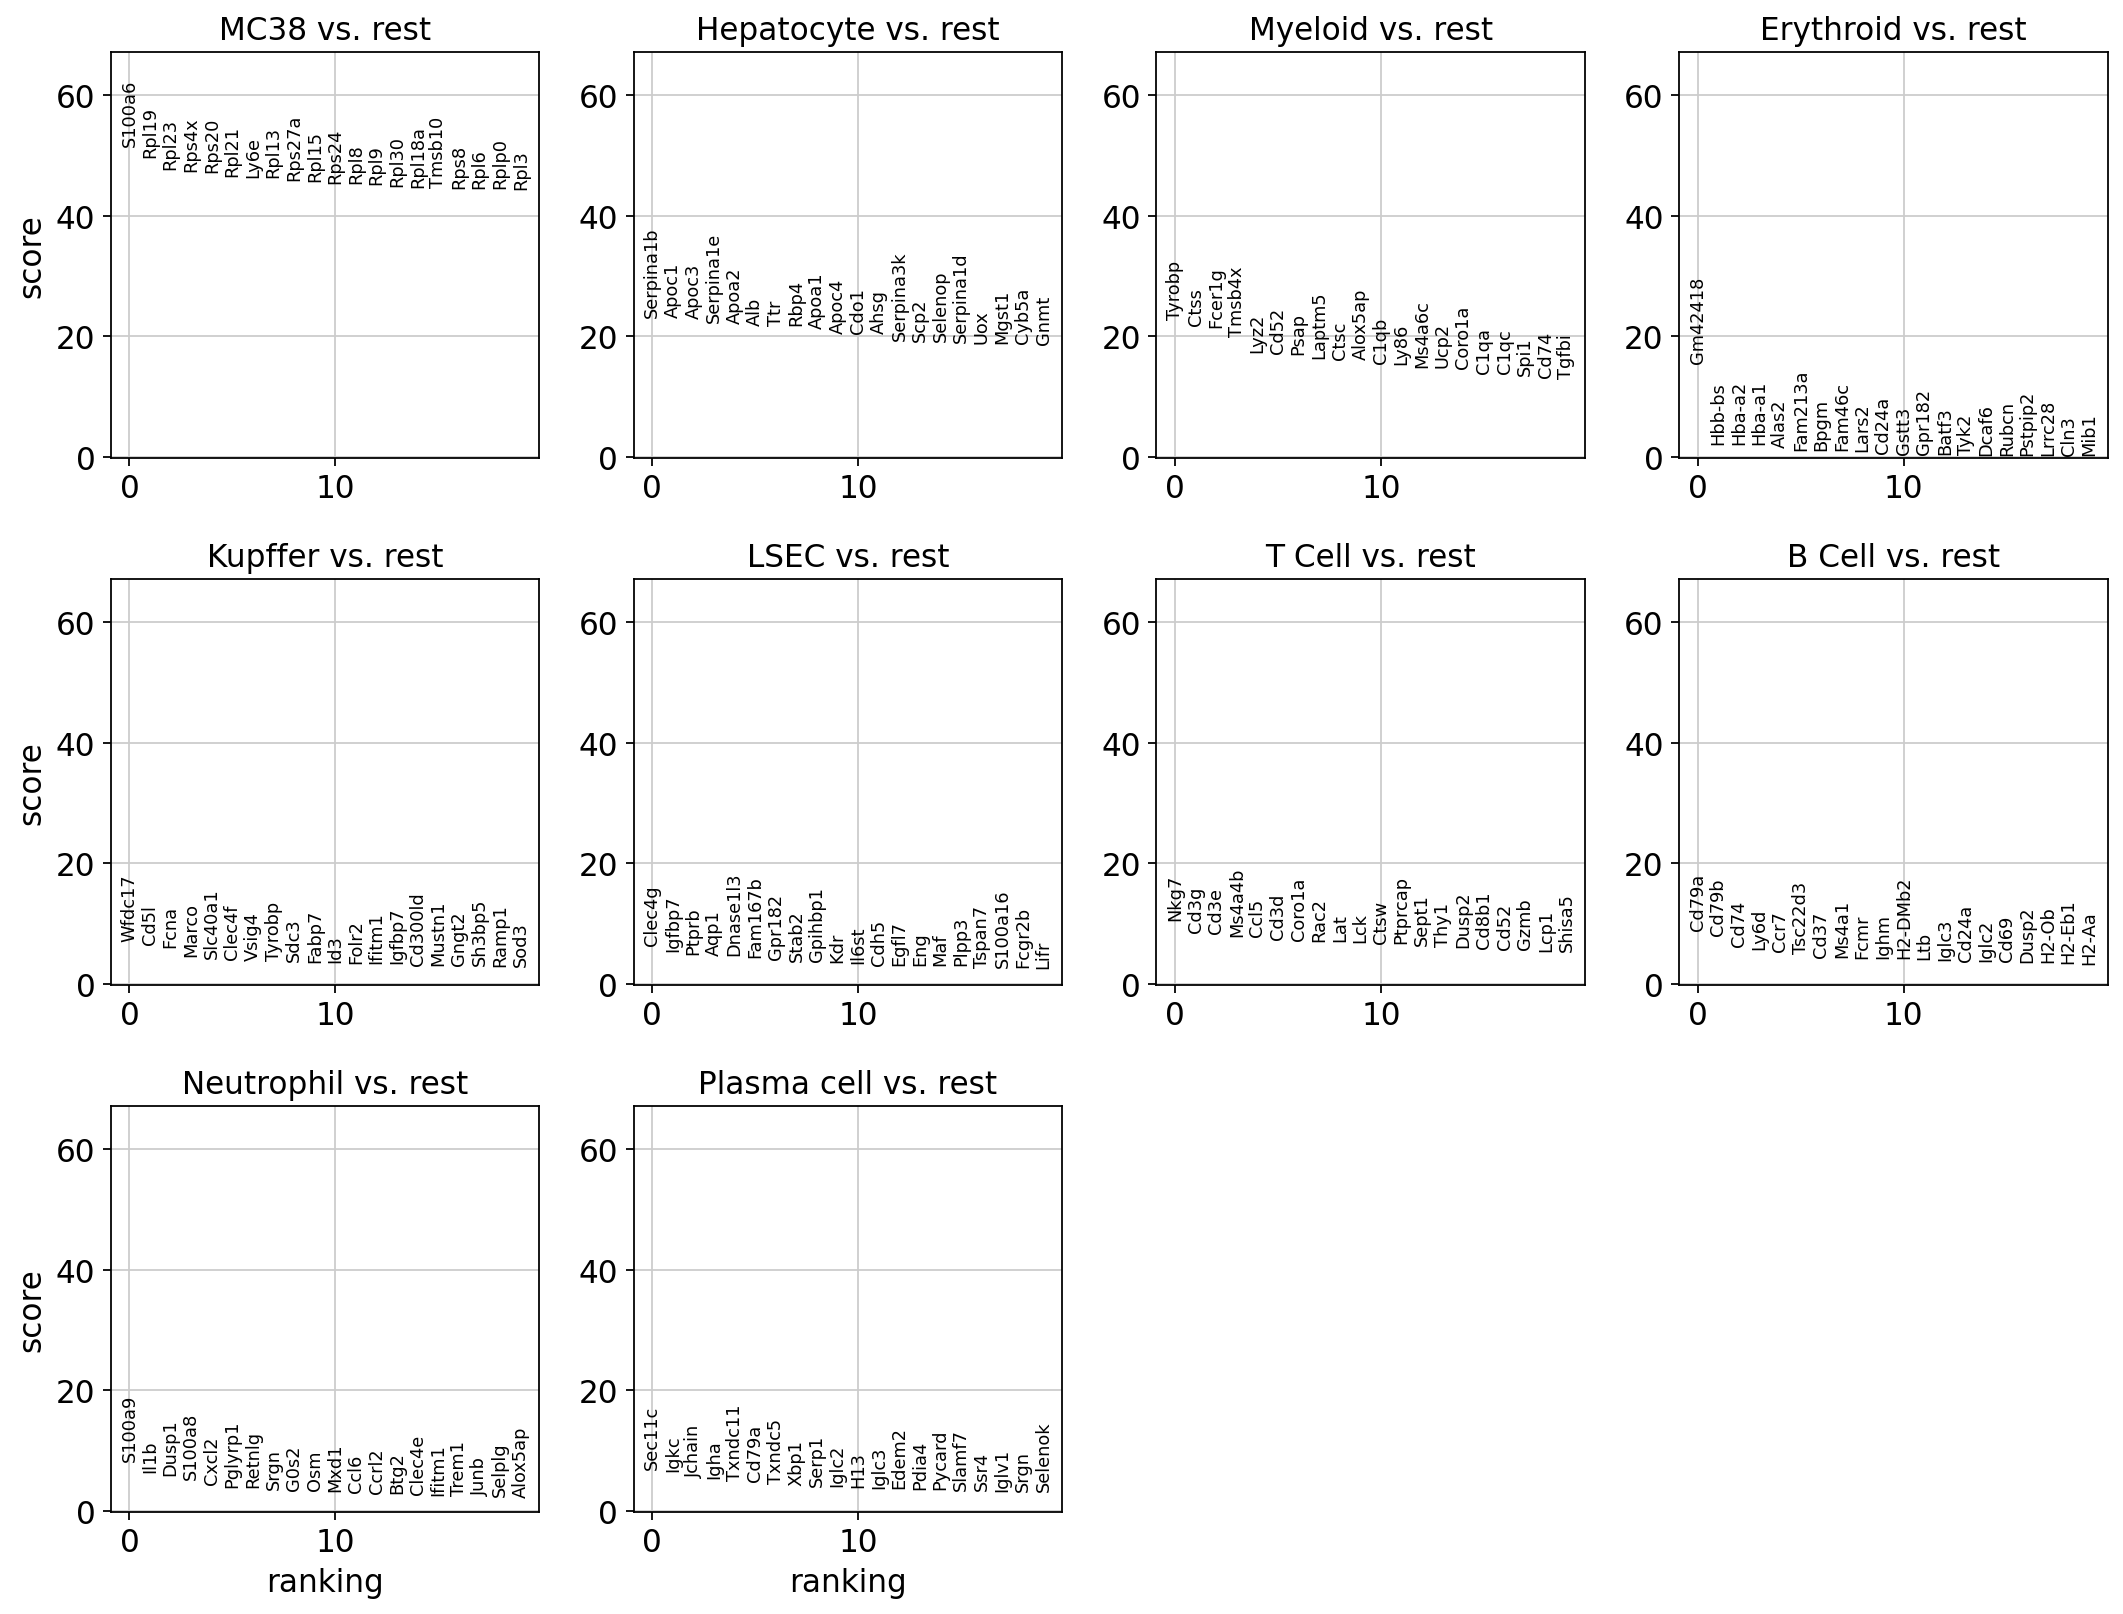

In [28]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_10x, groupby='celltype', n_genes=50)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata_10x, ncols=4, n_genes=20)
sc.settings.verbosity = 4

In [29]:
[list(adata_10x.uns['rank_genes_groups']['names'][i][:7]) for i in adata_10x.obs['celltype'].dtype.categories]

[['S100a6', 'Rpl19', 'Rpl23', 'Rps4x', 'Rps20', 'Rpl21', 'Ly6e'],
 ['Serpina1b', 'Apoc1', 'Apoc3', 'Serpina1e', 'Apoa2', 'Alb', 'Ttr'],
 ['Tyrobp', 'Ctss', 'Fcer1g', 'Tmsb4x', 'Lyz2', 'Cd52', 'Psap'],
 ['Gm42418', 'Hbb-bs', 'Hba-a2', 'Hba-a1', 'Alas2', 'Fam213a', 'Bpgm'],
 ['Wfdc17', 'Cd5l', 'Fcna', 'Marco', 'Slc40a1', 'Clec4f', 'Vsig4'],
 ['Clec4g', 'Igfbp7', 'Ptprb', 'Aqp1', 'Dnase1l3', 'Fam167b', 'Gpr182'],
 ['Nkg7', 'Cd3g', 'Cd3e', 'Ms4a4b', 'Ccl5', 'Cd3d', 'Coro1a'],
 ['Cd79a', 'Cd79b', 'Cd74', 'Ly6d', 'Ccr7', 'Tsc22d3', 'Cd37'],
 ['S100a9', 'Il1b', 'Dusp1', 'S100a8', 'Cxcl2', 'Pglyrp1', 'Retnlg'],
 ['Sec11c', 'Igkc', 'Jchain', 'Igha', 'Txndc11', 'Cd79a', 'Txndc5']]

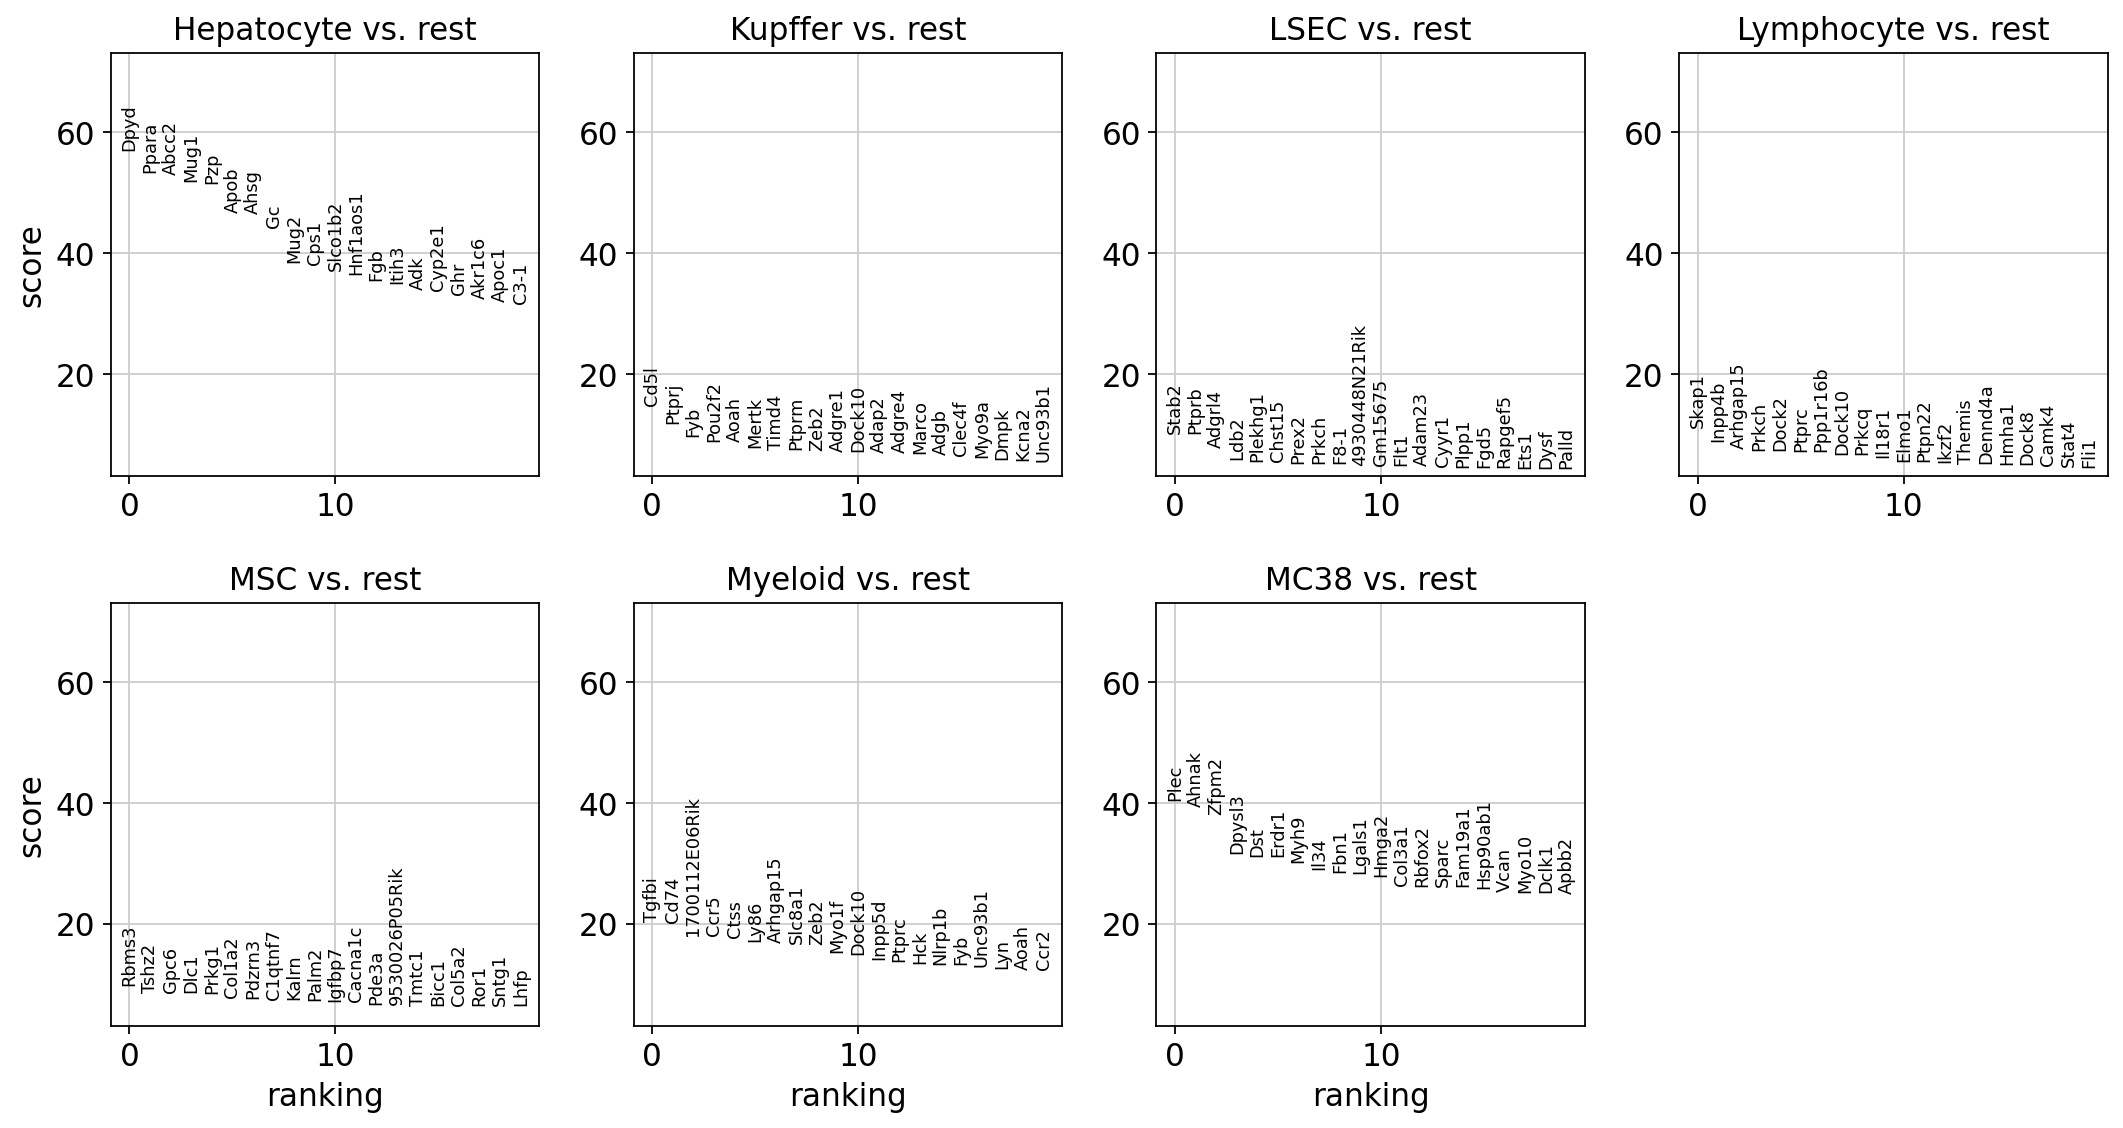

In [30]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(adata_xyz, groupby='celltype', n_genes=50)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(adata_xyz, ncols=4, n_genes=20)
sc.settings.verbosity = 4

In [31]:
[list(adata_xyz.uns['rank_genes_groups']['names'][i][:7]) for i in adata_xyz.obs['celltype'].dtype.categories]

[['Dpyd', 'Ppara', 'Abcc2', 'Mug1', 'Pzp', 'Apob', 'Ahsg'],
 ['Cd5l', 'Ptprj', 'Fyb', 'Pou2f2', 'Aoah', 'Mertk', 'Timd4'],
 ['Stab2', 'Ptprb', 'Adgrl4', 'Ldb2', 'Plekhg1', 'Chst15', 'Prex2'],
 ['Skap1', 'Inpp4b', 'Arhgap15', 'Prkch', 'Dock2', 'Ptprc', 'Ppp1r16b'],
 ['Rbms3', 'Tshz2', 'Gpc6', 'Dlc1', 'Prkg1', 'Col1a2', 'Pdzrn3'],
 ['Tgfbi', 'Cd74', '1700112E06Rik', 'Ccr5', 'Ctss', 'Ly86', 'Arhgap15'],
 ['Plec', 'Ahnak', 'Zfpm2', 'Dpysl3', 'Dst', 'Erdr1', 'Myh9']]

### Export for Safe Keeping

In [41]:
# adata_10x.write_h5ad(prefix + '/most.recent/10x.downsample.colors.cts.h5ad')
# adata_xyz.write_h5ad(prefix + '/most.recent/xyz.mouse.decontam.colors.cts.h5ad')
adata_10x = sc.read_h5ad(prefix + '/most.recent/10x.downsample.colors.cts.h5ad')
adata_xyz = sc.read_h5ad(prefix + '/most.recent/xyz.mouse.decontam.colors.cts.h5ad')

After exploring in `spatial/notebooks/10x/5prime_liver/check.10x.down.xyz.decontam.de.ipynb`, I'm only going to focus on certain cell types.

In [42]:
cts_10x = ['MC38', 'Hepatocyte', 'Kupffer', 'LSEC', 'T Cell', 'Myeloid']
cts_xyz = ['Hepatocyte', 'Kupffer', 'LSEC', 'Lymphocyte', 'Myeloid', 'MC38']

In [43]:
adata_10x_focus = adata_10x[adata_10x.obs['celltype'].isin(cts_10x)].copy()
adata_xyz_focus = adata_xyz[adata_xyz.obs['celltype'].isin(cts_xyz)].copy()

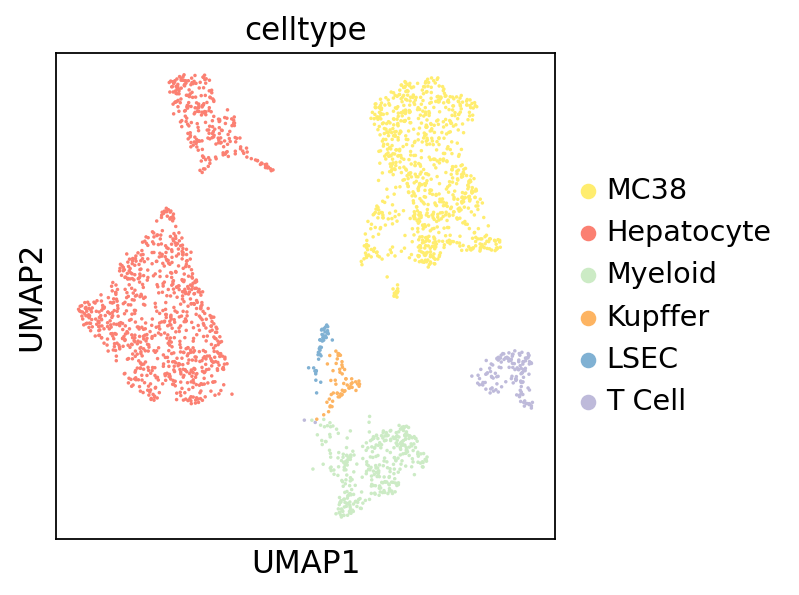

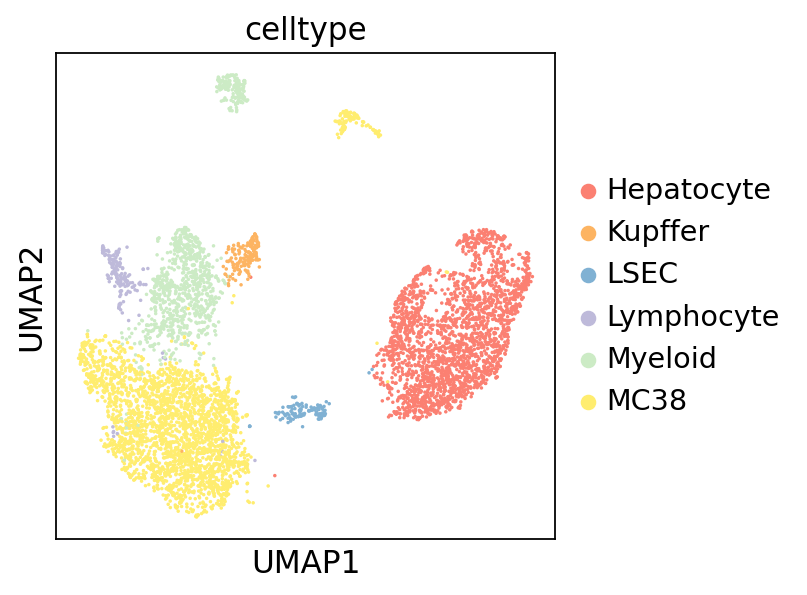

In [44]:
sc.pl.umap(adata_10x_focus,color=['celltype'], size=10)
sc.pl.umap(adata_xyz_focus,color=['celltype',], size=10)

In [45]:
ctdict = dict()
for ct in adata_10x_focus.obs['celltype']:
    ctdict['10X_%s' % ct] = [ct]

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_10x_focus.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_10x_focus.obs['celltype'] = adata_10x_focus.obs['celltype'].astype('category')

In [46]:
ctdict = dict()
for ct in adata_xyz_focus.obs['celltype']:
    ctdict['XYZ_%s' % ct] = [ct]

for ct in ctdict:
    for clust in ctdict[ct]:
        adata_xyz_focus.obs['celltype'].replace(clust, ct, regex=True, inplace=True)
adata_xyz_focus.obs['celltype'] = adata_xyz_focus.obs['celltype'].astype('category')

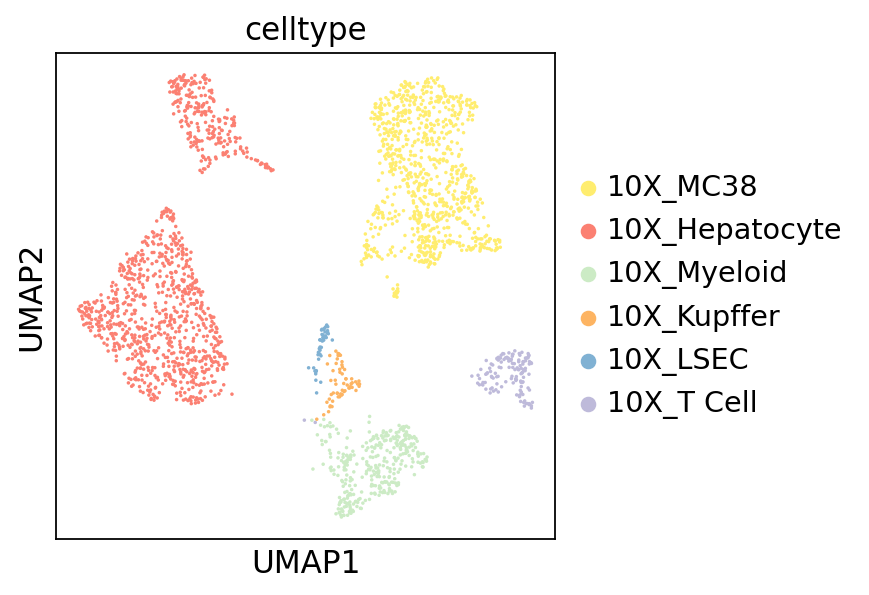

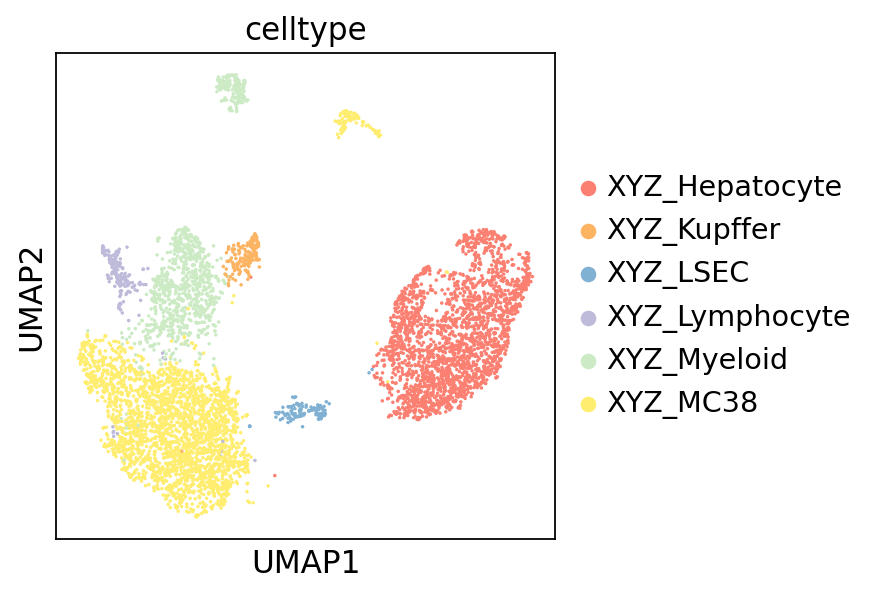

In [47]:
sc.pl.umap(adata_10x_focus,color=['celltype'], size=10)
sc.pl.umap(adata_xyz_focus,color=['celltype'], size=10)

### Correlate proportion in each Leiden cluster

In [48]:
ct_props = dict()

In [49]:
ct_props['xyzeq'] = dict()
ct_props['10x'] = dict()

ct_props['xyzeq']['cts'], ct_props['xyzeq']['counts'] = np.unique(adata_xyz_focus.obs['celltype'].values,return_counts=True)
ct_props['xyzeq']['props'] = np.apply_along_axis(lambda x: x/ct_props['xyzeq']['counts'].sum(), 0, arr=ct_props['xyzeq']['counts'])

ct_props['10x']['cts'], ct_props['10x']['counts'] = np.unique(adata_10x_focus.obs['celltype'].values,return_counts=True)
ct_props['10x']['props'] = np.apply_along_axis(lambda x: x/ct_props['10x']['counts'].sum(), 0, arr=ct_props['10x']['counts'])

ct_props['xyzeq']['dict'] = dict(zip(ct_props['xyzeq']['cts'], ct_props['xyzeq']['props']))
ct_props['10x']['dict'] = dict(zip(ct_props['10x']['cts'], ct_props['10x']['props']))

In [50]:
ct_props['xyzeq']['dict']

{'XYZ_Hepatocyte': 0.36013767209011266,
 'XYZ_Kupffer': 0.025500625782227785,
 'XYZ_LSEC': 0.020807259073842302,
 'XYZ_Lymphocyte': 0.02753441802252816,
 'XYZ_MC38': 0.41442428035043805,
 'XYZ_Myeloid': 0.15159574468085107}

In [51]:
ct_props['10x']['dict']

{'10X_Hepatocyte': 0.4213505863323898,
 '10X_Kupffer': 0.02426202992317024,
 '10X_LSEC': 0.017792155276991507,
 '10X_MC38': 0.34654266073594825,
 '10X_Myeloid': 0.13667610190052568,
 '10X_T Cell': 0.05337646583097452}

In [54]:
compare = {'XYZ_Hepatocyte':'10X_Hepatocyte',
           'XYZ_Kupffer':'10X_Kupffer',
           'XYZ_LSEC':'10X_LSEC',
           'XYZ_Lymphocyte':'10X_T Cell',
           'XYZ_MC38':'10X_MC38',
           'XYZ_Myeloid':'10X_Myeloid',
          }

In [55]:
x = [ct_props['xyzeq']['dict'][x] for x in compare.keys()]
y = [ct_props['10x']['dict'][x] for x in compare.values()]
n = compare.keys()

In [56]:
def ss (l): # one liner from https://stackoverflow.com/questions/26894227/sum-of-squares-in-a-list-in-one-line
    return np.array(sum(map(lambda x:x*x,l)))

# Next several functions from https://github.com/philrose/python/blob/master/stats.py
# Adjusted for python3 and consistency of variables
def lcov (x,y, keepdims=0):
    """
Returns the estimated covariance of the values in the passed
array (i.e., N-1).  Dimension can equal None (ravel array first), an
integer (the dimension over which to operate), or a sequence (operate
over multiple dimensions).  Set keepdims=1 to return an array with the
same number of dimensions as inarray.
Usage:   lcov(x,y,keepdims=0)
"""

    n = len(x)
    xmn = np.mean(x)
    ymn = np.mean(y)
    xdeviations = [0]*len(x)
    ydeviations = [0]*len(y)
    for i in range(len(x)):
        xdeviations[i] = x[i] - xmn
        ydeviations[i] = y[i] - ymn
    ss = 0.0
    for i in range(len(xdeviations)):
        ss = ss + xdeviations[i]*ydeviations[i]
    return ss/float(n-1)


def lvar (inlist):
    """
Returns the variance of the values in the passed list using N-1
for the denominator (i.e., for estimating population variance).
Usage:   lvar(inlist)
"""
    n = len(inlist)
    mn = np.mean(inlist)
    deviations = [0]*len(inlist)
    for i in range(len(inlist)):
        deviations[i] = inlist[i] - mn
    return ss(deviations)/float(n-1)


def amean (inarray,dimension=None,keepdims=0):
    """
Calculates the arithmatic mean of the values in the passed array.
That is:  1/n * (x1 + x2 + ... + xn).  Defaults to ALL values in the
passed array.  Use dimension=None to flatten array first.  REMEMBER: if
dimension=0, it collapses over dimension 0 ('rows' in a 2D array) only, and
if dimension is a sequence, it collapses over all specified dimensions.  If
keepdims is set to 1, the resulting array will have as many dimensions as
inarray, with only 1 'level' per dim that was collapsed over.
Usage:   amean(inarray,dimension=None,keepdims=0)
Returns: arithematic mean calculated over dim(s) in dimension
"""
    if inarray.dtype in [np.int_, np.short,np.ubyte]:
        inarray = inarray.astype(np.float_)
    if dimension == None:
        inarray = np.ravel(inarray)
        mysum = np.add.reduce(inarray)
        denom = float(len(inarray))
    elif type(dimension) in [IntType,FloatType]:
        mysum = amysum(inarray,dimension)
        denom = float(inarray.shape[dimension])
        if keepdims == 1:
            shp = list(inarray.shape)
            shp[dimension] = 1
            mysum = np.reshape(mysum,shp)
    else: # must be a TUPLE of dims to average over
        dims = list(dimension)
        dims.sort()
        dims.reverse()
        mysum = inarray *1.0
        for dim in dims:
            mysum = np.add.reduce(mysum,dim)
        denom = np.array(np.multiply.reduce(np.take(inarray.shape,dims)),np.float_)
        if keepdims == 1:
            shp = list(inarray.shape)
            for dim in dims:
                shp[dim] = 1
            mysum = np.reshape(mysum,shp)
    return mysum/denom

def llincc(x,y):
    """
Calculates Lin's concordance correlation coefficient.
Usage:   alincc(x,y)    where x, y are equal-length arrays
Returns: Lin's CC
"""
    covar = lcov(x,y)*(len(x)-1)/float(len(x))  # correct denom to n
    xvar = lvar(x)*(len(x)-1)/float(len(x))  # correct denom to n
    yvar = lvar(y)*(len(y)-1)/float(len(y))  # correct denom to n
    lincc = (2 * covar) / ((xvar+yvar) +((amean(x)-amean(y))**2))
    return lincc

In [57]:
lincc = llincc(np.array(x), np.array(y))
print(lincc)

0.9704280942858159


In [60]:
corr_colors = [
    paper_colormap['Hepatocyte'],
    paper_colormap['Kupffer'],
    paper_colormap['LSEC'],
    paper_colormap['Lymphocyte'],
    paper_colormap['MC38'],
    paper_colormap['Macrophage']
]

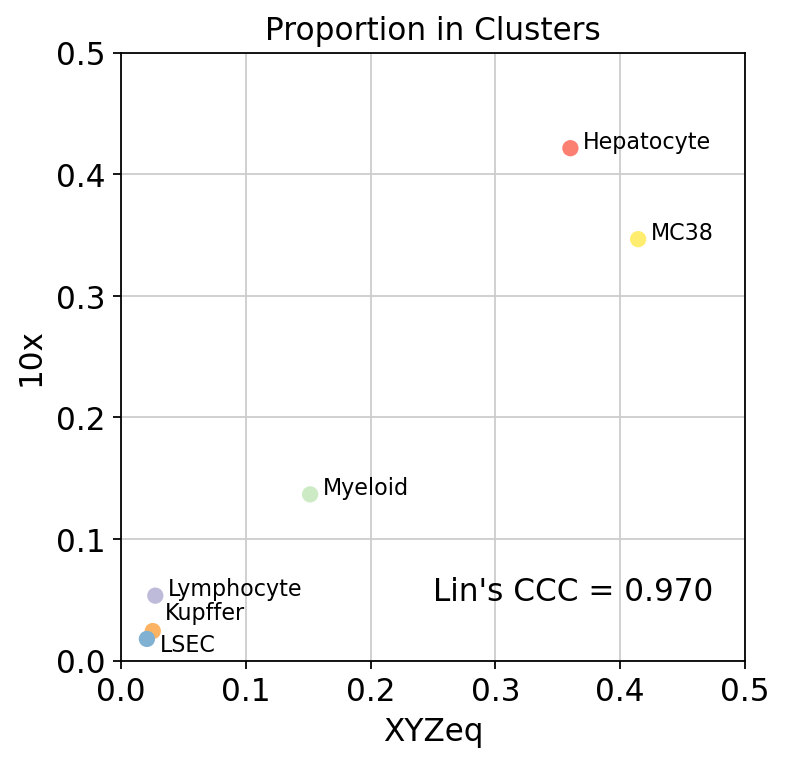

In [62]:
plt.figure(figsize=(5,5))
plt.scatter(x, y, color=corr_colors, s=40);
plt.title('Proportion in Clusters')
plt.xlabel('XYZeq')
plt.ylabel('10x')
plt.xlim(0,0.5)
plt.xticks(np.arange(0, 0.6, 0.1))
plt.ylim(0,0.5)
ax = plt.gca()
for i, txt in enumerate(n):
    if txt == 'XYZ_Kupffer':
        ax.annotate(txt.strip('XYZ_'), (x[i]+0.01, y[i]+0.01), size=10)
    elif txt == 'XYZ_LSEC':
        ax.annotate(txt.strip('XYZ_'), (x[i]+0.01, y[i]-0.01), size=10)        
    else:
        ax.annotate(txt.strip('XYZ_'), (x[i]+0.01, y[i]), size=10)

plt.text(0.25, 0.05, "Lin's CCC = " + str(lincc)[:5]);
# plt.savefig("/data/xyzeq/figures/10X.down.XYZ.decontam/gh.for.youjin.03OCT20/S3/props.mono.svg")
plt.show()

In [63]:
for adata, label in zip([adata_10x, adata_xyz], ['10x', 'xyz']):
    sc.pl.umap(adata, color='celltype', size=10, save=".cts.%s.svg" % label, return_fig=False, show=False)
plt.close()

In [64]:
for adata, label in zip([adata_10x, adata_xyz], ['10x', 'xyz']):
    sc.pl.tsne(adata, color='celltype', size=10, save=".cts.%s.svg" % label, return_fig=False, show=False)
plt.close()

In [65]:
for adata, label in zip([adata_10x, adata_xyz], ['10x', 'xyz']):
    sc.pl.tsne(adata, color='leiden', size=10, palette=sc.pl.palettes.default_20, save=".leiden.%s.svg" % label, return_fig=False, show=False)
# plt.close()